<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil, os
# shutil.rmtree("game_logs")
if os.path.exists('game_logs'):
  shutil.rmtree("game_logs")
if os.path.exists('validation'):
  shutil.rmtree("validation")
shutil.unpack_archive('game_logs.zip', './')
shutil.unpack_archive('validation.zip', './')
print(len(os.listdir('game_logs')))
print(len(os.listdir('validation')))
train_filenames = os.listdir('game_logs')
val_filenames = os.listdir('validation')
train_filenames.sort()
val_filenames.sort()
print(train_filenames[0], val_filenames[0])

18122
1000
316756.npz 402311.npz


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
# Constants
T = 1 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [ ]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize, folder_name) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.folder_name = folder_name
    self.boards_per_game = 4
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    legal_moves = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join(self.folder_name, f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
      legal_moves.extend(loaded['legal_moves'][index])
    
    # Y_new = []
    # for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return (np.array(inputs), np.array(legal_moves)), np.array(outputs)

In [ ]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True, 'game_logs')
validation_generator = My_Custom_Generator(val_filenames, batch_size, False, 'validation')

In [ ]:
inputs = tf.keras.Input(shape=(20, 8, 8))
legal_moves_input = tf.keras.Input(shape = (1858))
x1 = tf.keras.layers.LeakyReLU()(inputs)


x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(20, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(60, (3,3),activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1858, activation = 'relu')(x)


x = tf.keras.layers.Multiply()([x, legal_moves_input])

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs = [inputs, legal_moves_input], outputs = x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8, 8)]   0           []                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 20, 8, 8)     0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 8, 8)    23168       ['leaky_re_lu[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 8, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                   

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [ ]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 30,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(1000 // batch_size)  # Use only 1000 samples for validation
                  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
566/566 [==============================] - 125s 221ms/step - loss: 4.5488 - categorical_accuracy: 0.3931 - val_loss: 5.5675 - val_categorical_accuracy: 0.2281
Epoch 2/30
566/566 [==============================] - 125s 221ms/step - loss: 4.4948 - categorical_accuracy: 0.3996 - val_loss: 5.5514 - val_categorical_accuracy: 0.2257
Epoch 3/30
566/566 [==============================] - 125s 221ms/step - loss: 4.4928 - categorical_accuracy: 0.4002 - val_loss: 5.5648 - val_categorical_accuracy: 0.2256
Epoch 4/30
566/566 [==============================] - 125s 221ms/step - loss: 4.4995 - categorical_accuracy: 0.4008 - val_loss: 5.5625 - val_categorical_accuracy: 0.2303
Epoch 5/30
566/566 [==============================] - 123s 218ms/step - loss: 4.4570 - categorical_accuracy: 0.4046 - val_loss: 5.5550 - val_categorical_accuracy: 0.2272
Epoch 6/30
566/566 [==============================] - 129s 228ms/step - loss: 4.4584 - categorical_accuracy: 0.4065 - val_loss: 5.5684 - val_categoric

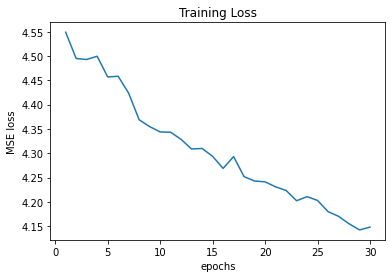

In [ ]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

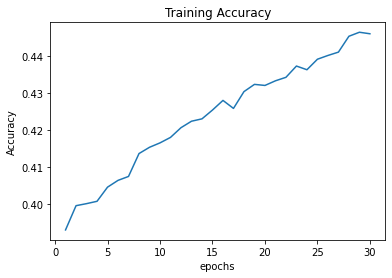

In [ ]:
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

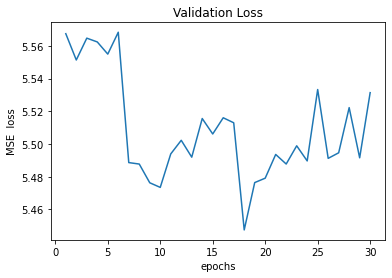

In [ ]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('MSE  loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

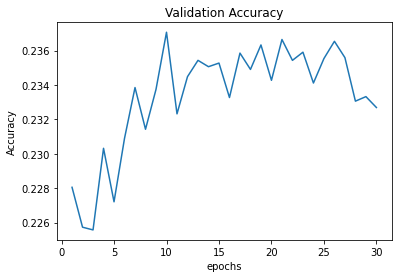

In [ ]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [ ]:
print(history.history)

{'loss': [4.548841953277588, 4.494830131530762, 4.492849349975586, 4.499471664428711, 4.45695161819458, 4.4583659172058105, 4.423629283905029, 4.368971347808838, 4.354830265045166, 4.343929290771484, 4.343246936798096, 4.328603744506836, 4.308765411376953, 4.309924602508545, 4.293741703033447, 4.268929958343506, 4.293115139007568, 4.251904487609863, 4.243034362792969, 4.241311550140381, 4.230944633483887, 4.22367000579834, 4.202425956726074, 4.210852146148682, 4.203034400939941, 4.18002986907959, 4.170388221740723, 4.155089855194092, 4.142448902130127, 4.148149490356445], 'categorical_accuracy': [0.3930984139442444, 0.39964044094085693, 0.4001910090446472, 0.4008258581161499, 0.4046405255794525, 0.4064747095108032, 0.40753382444381714, 0.413713663816452, 0.41540491580963135, 0.41659411787986755, 0.41807353496551514, 0.42069634795188904, 0.42244163155555725, 0.42308393120765686, 0.42545750737190247, 0.42805978655815125, 0.42590096592903137, 0.430433452129364, 0.43238765001296997, 0.4321

In [ ]:
from google.colab import files

folder_name = "saved-model"

if os.path.exists(folder_name):
  shutil.rmtree(folder_name)
os.mkdir(folder_name)

if os.path.exists(folder_name + ".zip"):
  os.remove(folder_name + ".zip")
model.save(folder_name)

shutil.make_archive(folder_name, 'zip', folder_name)
files.download(folder_name + ".zip")

INFO:tensorflow:Assets written to: saved-model/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>